In [0]:
# Some data-handling functions to download/import.

"""I load some cifar"""

import numpy as np
from sklearn.model_selection import train_test_split
import os, sys
if sys.version_info[0] == 2:
    from urllib import urlretrieve
    import cPickle as pickle

else:
    from urllib.request import urlretrieve
    import pickle

def unpickle(file):
    fo = open(file, 'rb')
    if sys.version_info[0] == 2:
        dict = pickle.load(fo)
    else:
        dict = pickle.load(fo,encoding='latin1')
    
    fo.close()
    return dict




def download_cifar10(path,
                     url='https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
                     tarname='cifar-10-python.tar.gz',):
    import tarfile
    if not os.path.exists(path):
        os.mkdir(path)
    
        

    urlretrieve(url, os.path.join(path,tarname))
    tfile = tarfile.open(os.path.join(path,tarname))
    tfile.extractall(path=path)
    

def load_cifar10(data_path=".",channels_last=False,test_size=0.2,random_state=1337):
    
    test_path = os.path.join(data_path,"cifar-10-batches-py/test_batch")
    train_paths = [os.path.join(data_path,"cifar-10-batches-py/data_batch_%i"%i) for i in range(1,6)]
    
    if not os.path.exists(test_path) or not all(list(map(os.path.exists, train_paths))):
        print ("Dataset not found. Downloading...")
        download_cifar10(data_path)

    train_batches = list(map(unpickle,train_paths))
    test_batch = unpickle(test_path)

    X = np.concatenate([batch["data"] for batch in train_batches]).reshape([-1,3,32,32]).astype('float32')/255
    y = np.concatenate([batch["labels"] for batch in train_batches]).astype('int32')
    X_train,X_val,y_train,y_val = train_test_split(X,y,
                                                   test_size=test_size,
                                                   random_state=random_state)
    
    X_test = test_batch["data"].reshape([-1,3,32,32]).astype('float32')/255
    y_test = np.array(test_batch["labels"]).astype('int32')
    
    if channels_last:
        #convert from [batch,3,H,W] to [batch,H,W,3]
        #WARNING! Make this is only necessary for tensorflow-style dim order
        #If you use theano-style dimensions in keras config, skip this cell
        X_train = X_train.transpose([0,2,3,1])
        X_val   = X_val.transpose([0,2,3,1])
        X_test  = X_test.transpose([0,2,3,1])

    
    return X_train,y_train,X_val,y_val,X_test,y_test

In [0]:
import tensorflow as tf
#gpu_options = tf.GPUOptions(allow_growth=True, per_process_gpu_memory_fraction=0.1) # restricts GPU load for multi-user nodes

import keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)

1.15.0
2.2.5


Using TensorFlow backend.


In [0]:
# Load the data samples

x_train,y_train,x_val,y_val,x_test,y_test = load_cifar10("cifar_data",channels_last=True)

NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)
print("Val samples:", x_val.shape, y_val.shape)

Dataset not found. Downloading...
Train samples: (40000, 32, 32, 3) (40000,)
Test samples: (10000, 32, 32, 3) (10000,)
Val samples: (10000, 32, 32, 3) (10000,)


TypeError: ignored

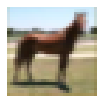

In [0]:
# show some random images from train, and their labels

cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[ [random_index]])
plt.show()

In [0]:
# normalize inputs
# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)
# x_train = x_train.astype(np.float64) - 0.5

y_train = keras.utils.to_categorical(y_train, num_classes=10)

y_val = keras.utils.to_categorical(y_val, num_classes=10)

y_test = keras.utils.to_categorical(y_test, num_classes=10)

In [0]:
# import necessary building blocks
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras import regularizers

References:

https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/

https://appliedmachinelearning.blog/2018/03/24/achieving-90-accuracy-in-object-recognition-task-on-cifar-10-dataset-with-keras-convolutional-neural-networks/

as well as keras documentation to try and understand what each layer/function does

In [0]:
''' the architecture used for both models is based on VGG, which consists of blocks of convolution layers followed by pooling,
     for this is chose 3 blocks of 2 layers, ranging from 64 nodes to 128 using Relu activation, the last block, after flattening, is a dense layer of 128 nodes
     BatchNormalization, Dropout and kernel regularizers were added to avoid overfitting and improve the performance of the model'''


def make_model0():
    
    model = Sequential()

    ### STUDENT CODE HERE ###
    #BLOCK 1
    model.add(Conv2D(64, (3, 3), activation='relu',padding='same', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    
    #BLOCK 2
    model.add(Conv2D(96, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(96, (3, 3), activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))  
    model.add(Dropout(0.2))
   
    #BLOCK 3
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))   
    model.add(Dropout(0.2))
    
    #FLATTENING + FINAL BLOCK
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    return model
    
def make_model1():
  
    model = Sequential()

    ### STUDENT CODE HERE ###
    weight_decay=1e-4
    model.add(Conv2D(64, (3, 3), activation='relu',padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(96, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Conv2D(96, (3, 3), activation='relu',padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))  
    model.add(Dropout(0.4))
   
    
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))  
   
    

    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    return model

In [111]:
### STUDENT CODE HERE ###
### --> change the parameters below to perform a better training
''' here we use the first model, the goal is to get to 80% accuracy as fast as possible
in this case we can arrive to 80% in approximately 10 epochs which translates to around 1min of runtime '''
INIT_LR = 1e-3  # initial learning rate
BATCH_SIZE =128 #Higher batch sizes provide ess accuracy at 10-20 epochs and smaller ones increase runtime
EPOCHS = 20



K.clear_session()  # clear default graph
# don't call K.set_learning_phase() !!! (otherwise will enable dropout in train/test simultaneously)
model = make_model0()  # define our model

# prepare model for fitting (loss, optimizer, etc)
''' Adam optimizer was chosen due to it's adapatative learning rate, making the training a lot faster'''
model.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=keras.optimizers.Adam(lr=INIT_LR),  
    metrics=['accuracy']  # report accuracy during training
)

# fit model
model.fit(
    x_train, y_train,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    shuffle=True,
)

# save weights to file to avoid re-training
model.save_weights("weights.h5")

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 9s 213us/step - loss: 1.4488 - acc: 0.4823 - val_loss: 1.3777 - val_acc: 0.5455
Epoch 2/20
40000/40000 [==============================] - 7s 183us/step - loss: 0.9543 - acc: 0.6580 - val_loss: 0.9433 - val_acc: 0.6690
Epoch 3/20
40000/40000 [==============================] - 7s 183us/step - loss: 0.7494 - acc: 0.7341 - val_loss: 0.8791 - val_acc: 0.7033
Epoch 4/20
40000/40000 [==============================] - 7s 183us/step - loss: 0.6364 - acc: 0.7748 - val_loss: 0.9841 - val_acc: 0.6825
Epoch 5/20
40000/40000 [==============================] - 7s 183us/step - loss: 0.5425 - acc: 0.8084 - val_loss: 0.6875 - val_acc: 0.7680
Epoch 6/20
40000/40000 [==============================] - 7s 183us/step - loss: 0.4685 - acc: 0.8357 - val_loss: 0.7860 - val_acc: 0.7464
Epoch 7/20
40000/40000 [==============================] - 7s 183us/step - loss: 0.4084 - acc: 0.8550 - val_loss: 0.7055 - 

In [113]:
### STUDENT CODE HERE ###
### --> change the parameters below to perform a better training
'''the goal here is to get a 90% accuracy regardless of time usage (goal is 90% accuracy @100-150 epochs),
 allowing for the use of data augmentnation'''
INIT_LR = 1e-3  # initial learning rate
BATCH_SIZE =128
EPOCHS = 150
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler   

#data augmentation
datagen = ImageDataGenerator(
    rotation_range=15, #image will be rotated of a maximum of 15deg in each direction
    width_shift_range=0.1, #zoom-in/out 
    height_shift_range=0.1,
    horizontal_flip=True, #MIRROR IMAGE OF ORIGINAL
    )
datagen.fit(x_train)


K.clear_session()  # clear default graph
# don't call K.set_learning_phase() !!! (otherwise will enable dropout in train/test simultaneously)
model = make_model1()  # define our model

# prepare model for fitting (loss, optimizer, etc)
'''adam optimizer was replaced by rmsprop which seems to have better accuracy in the long run'''
''' learning rate has to be changed manually through keras.callback.LearningRateScheduler
    which takes the following fucntion as an input argument'''
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    if epoch > 100:
        lrate = 0.0003
    return lrate

model.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=keras.optimizers.rmsprop(lr=INIT_LR, decay=1e-6),  
    metrics=['accuracy']  # report accuracy during training
)

# fit model
model.fit_generator(
    datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),  #prepared data (augmented)
    steps_per_epoch=x_train.shape[0] // BATCH_SIZE,  
    epochs=EPOCHS,
    callbacks=[LearningRateScheduler(lr_schedule)],   #callback allows for realtime modification of certain parameters, in this case it is learning rate
    validation_data=(x_val, y_val),
    shuffle=True,
)

# save weights to file to avoid re-training
model.save_weights("weights.h5")

Epoch 1/150
625/625 [==============================] - 22s 35ms/step - loss: 1.6693 - acc: 0.4400 - val_loss: 1.4655 - val_acc: 0.5484
Epoch 2/150
625/625 [==============================] - 20s 33ms/step - loss: 1.1707 - acc: 0.6103 - val_loss: 1.0606 - val_acc: 0.6640
Epoch 3/150
625/625 [==============================] - 21s 33ms/step - loss: 1.0179 - acc: 0.6746 - val_loss: 0.9816 - val_acc: 0.7042
Epoch 4/150
625/625 [==============================] - 21s 33ms/step - loss: 0.9447 - acc: 0.7057 - val_loss: 1.2771 - val_acc: 0.6421
Epoch 5/150
625/625 [==============================] - 21s 33ms/step - loss: 0.8974 - acc: 0.7301 - val_loss: 0.9231 - val_acc: 0.7381
Epoch 6/150
625/625 [==============================] - 20s 33ms/step - loss: 0.8594 - acc: 0.7446 - val_loss: 1.1549 - val_acc: 0.6591
Epoch 7/150
625/625 [==============================] - 21s 33ms/step - loss: 0.8409 - acc: 0.7542 - val_loss: 0.8852 - val_acc: 0.7493
Epoch 8/150
625/625 [==============================] - 

In [0]:
# load weights from file (can call without model.fit)
model.load_weights("weights.h5")

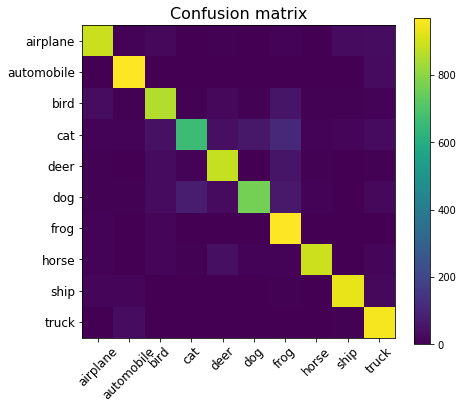

Test accuracy: 0.8788


In [115]:
# make test predictions
y_pred_test = model.predict_proba(x_test)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)
y_test_index = [list(onehot).index(1) for onehot in y_test]

# confusion matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(y_test_index, y_pred_test_classes))
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar()
plt.show()
print("Test accuracy:", accuracy_score(y_test_index, y_pred_test_classes))

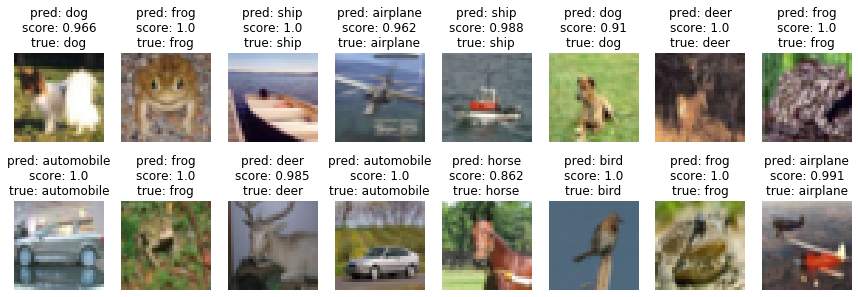

In [116]:
# inspect preditions
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index, :])
        pred_label = cifar10_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar10_classes[y_test_index[random_index]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()

# Some tips on how to improve:

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.

## Potential grading:
* starting at zero points
* +2 for describing your iteration path in a report below.
* +2 for building a network that gets above 20% accuracy
* +1 for beating each of these milestones on __TEST__ dataset:
    * 50% (5 total)
    * 60% (6 total)
    * 65% (7 total)
    * 70% (8 total)
    * 75% (9 total)
    * 80% (10 total)

## Bonus points
Common ways to get bonus points are:
* Get higher score, obviously.
* Anything special about your NN. For example \"A super-small/fast NN that gets 80%\" gets a bonus.
* Any detailed analysis of the results. (saliency maps, whatever)

## Restrictions
* Please do NOT use pre-trained networks for this assignment until you reach 80%.
 * In other words, base milestones must be beaten without pre-trained nets (and such net must be present in the e-mail). After that, you can use whatever you want.
* you __can__ use validation data for training, but you __can't'__ do anything with test data apart from running the evaluation procedure.

## Tips on what can be done:

 * __Network size__
   * MOAR neurons, 
   * MOAR layers, ([lasagne docs](http://lasagne.readthedocs.org))
   * Nonlinearities in the hidden layers
   * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

 * __Convolution layers__
   * they __are a must__ unless you have any super-ideas
   * `network = lasagne.layers.Conv2DLayer(prev_layer,`
     `                       num_filters = n_neurons,`
     `                       filter_size = (filter width, filter height),`
     `                       nonlinearity = some_nonlinearity)`
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment to try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.

   * Plenty other layers and architectures
     * http://lasagne.readthedocs.org/en/latest/modules/layers.html
     * batch normalization, pooling, etc


 * __Early Stopping__
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum


 * __Faster optimization__ - 
   * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (lasagne.layers.batch_norm) FTW!


 * __Regularize__ to prevent overfitting
   * Add some L2 weight norm to the loss function, theano will do the rest
     * Can be done manually or via - http://lasagne.readthedocs.org/en/latest/modules/regularization.html
   * Dropout - to prevent overfitting
     * `lasagne.layers.DropoutLayer(prev_layer, p=probability_to_zero_out)`   
     * Don't overdo it. Check if it actually makes your network better


 * __Data augmemntation__ - getting 5x as large dataset for free is a great deal
   * Zoom-in+slice = move
   * Rotate+zoom(to remove black stripes)
   * any other perturbations
   * Add Noize (easiest: GaussianNoizeLayer)
   * Simple way to do that (if you have PIL/Image): 
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.


